In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv("../data/final/healthcare_efficiency_master.csv")

# I need this tier from 01 Notebook
def efficiency_tier(gap):
    if gap <= 25:
        return 'High'
    elif gap <= 60:
        return 'Medium'
    else:
        return 'Low'

# Get provincial efficiency data
provincial_stats = df.groupby('province').agg({
    'raw_efficiency': 'mean',
    'avg_wait_time': 'mean',
    'total_spending_per_capita': 'mean'
}).round(1)

best_efficiency = provincial_stats['raw_efficiency'].max()
provincial_stats['efficiency_gap'] = best_efficiency - provincial_stats['raw_efficiency']
provincial_stats['efficiency_tier'] = provincial_stats['efficiency_gap'].apply(efficiency_tier)

print("Efficiency tier distribution:")
print(provincial_stats['efficiency_tier'].value_counts())

Efficiency tier distribution:
efficiency_tier
Low       5
Medium    3
High      2
Name: count, dtype: int64


In [2]:
# Calculate spending by category
spending_categories = ['hospitals', 'physicians', 'drugs', 'administration', 'other_professionals', 'public_health']

provincial_spending = df.groupby('province').agg({
    'hospitals': 'mean',
    'physicians': 'mean',
    'drugs': 'mean', 
    'administration': 'mean',
    'other_professionals': 'mean',
    'public_health': 'mean',
    'admin_overhead_pct': 'mean',
    'clinical_focus_pct': 'mean',
    'avg_wait_time': 'mean'
}).round(1)

provincial_spending = provincial_spending.merge(provincial_stats[['efficiency_tier']], left_index=True, right_index=True)

# Calculate spending efficiency (spending per day of wait time, higher = more strategic investment)
for category in spending_categories:
    provincial_spending[f'{category}_efficiency'] = provincial_spending[category] / provincial_spending['avg_wait_time']

spending_efficiency_table = provincial_spending[['hospitals_efficiency', 'physicians_efficiency', 'administration_efficiency', 'efficiency_tier']].round(1)
spending_efficiency_table.columns = ['Hospital_Investment', 'Physician_Investment', 'Admin_Investment', 'Tier']

print("Strategic Investment by Category (higher = more investment per wait day):")
print(spending_efficiency_table.sort_values('Hospital_Investment', ascending=False))

Strategic Investment by Category (higher = more investment per wait day):
                           Hospital_Investment  Physician_Investment  \
province                                                               
Ontario                                   51.1                  28.3   
Newfoundland and Labrador                 48.3                  16.9   
Alberta                                   38.3                  20.7   
British Columbia                          34.7                  19.3   
New Brunswick                             34.5                  13.4   
Saskatchewan                              32.8                  16.9   
Nova Scotia                               31.8                  12.1   
Prince Edward Island                      29.4                  12.3   
Manitoba                                  27.4                  12.8   
Quebec                                    26.4                  13.7   

                           Admin_Investment    Tier  
provinc

In [3]:
# Compare high vs low efficiency provinces
high_performers = provincial_spending[provincial_spending['efficiency_tier'] == 'High']
low_performers = provincial_spending[provincial_spending['efficiency_tier'] == 'Low']

print(f"High Efficiency Provinces ({len(high_performers)}): {list(high_performers.index)}")
print(f"Low Efficiency Provinces ({len(low_performers)}): {list(low_performers.index)}")

# Key metrics comparison
comparison_metrics = ['admin_overhead_pct', 'clinical_focus_pct', 'hospitals', 'physicians', 'administration']

comparison_table = pd.DataFrame({
    'High_Efficiency_Avg': [high_performers[metric].mean() for metric in comparison_metrics],
    'Low_Efficiency_Avg': [low_performers[metric].mean() for metric in comparison_metrics],
    'Difference': [high_performers[metric].mean() - low_performers[metric].mean() for metric in comparison_metrics]
}, index=comparison_metrics).round(1)

print("\nStrategy Comparison Table:")
print(comparison_table)

High Efficiency Provinces (2): ['Newfoundland and Labrador', 'Ontario']
Low Efficiency Provinces (5): ['Manitoba', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island', 'Quebec']

Strategy Comparison Table:
                    High_Efficiency_Avg  Low_Efficiency_Avg  Difference
admin_overhead_pct                  2.6                 3.2        -0.6
clinical_focus_pct                 43.0                42.2         0.7
hospitals                        2201.6              2080.0       121.5
physicians                        955.3               894.7        60.6
administration                    193.7               225.3       -31.6


In [4]:
# T-tests comparing high vs low efficiency provinces
test_metrics = ['admin_overhead_pct', 'clinical_focus_pct', 'hospitals', 'physicians', 'administration']

test_results = []
for metric in test_metrics:
    if len(high_performers) > 1 and len(low_performers) > 1:
        high_values = high_performers[metric].values
        low_values = low_performers[metric].values
        t_stat, p_val = stats.ttest_ind(high_values, low_values)
        
        test_results.append({
            'Metric': metric,
            'T_Statistic': round(t_stat, 3),
            'P_Value': round(p_val, 4),
            'Significant': p_val < 0.1
        })

test_results_df = pd.DataFrame(test_results)
print("Statistical Testing Results:")
print(test_results_df)

Statistical Testing Results:
               Metric  T_Statistic  P_Value  Significant
0  admin_overhead_pct       -2.417   0.0603         True
1  clinical_focus_pct        0.403   0.7038        False
2           hospitals        0.424   0.6889        False
3          physicians        1.331   0.2405        False
4      administration       -1.084   0.3277        False


/Users/thedarianwong/Downloads/CMPT 353/Data Science/Project/healthcare-efficiency-canada/healthcare_venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [5]:
# Administrative overhead correlation with efficiency
admin_efficiency_corr, admin_p = stats.pearsonr(provincial_spending['admin_overhead_pct'], 
                                                provincial_stats['raw_efficiency'])

print("Administrative Efficiency Analysis:")
print(f"Admin overhead vs efficiency correlation: r = {admin_efficiency_corr:.3f} (p = {admin_p:.4f})")

# Administrative overhead by tier
admin_by_tier = provincial_spending.groupby('efficiency_tier')['admin_overhead_pct'].agg(['mean', 'count']).round(1)
admin_by_tier.columns = ['Avg_Admin_Overhead_Pct', 'Province_Count']

print("\nAdministrative Overhead by Efficiency Tier:")
print(admin_by_tier)

Administrative Efficiency Analysis:
Admin overhead vs efficiency correlation: r = -0.672 (p = 0.0332)

Administrative Overhead by Efficiency Tier:
                 Avg_Admin_Overhead_Pct  Province_Count
efficiency_tier                                        
High                                2.6               2
Low                                 3.2               5
Medium                              3.1               3


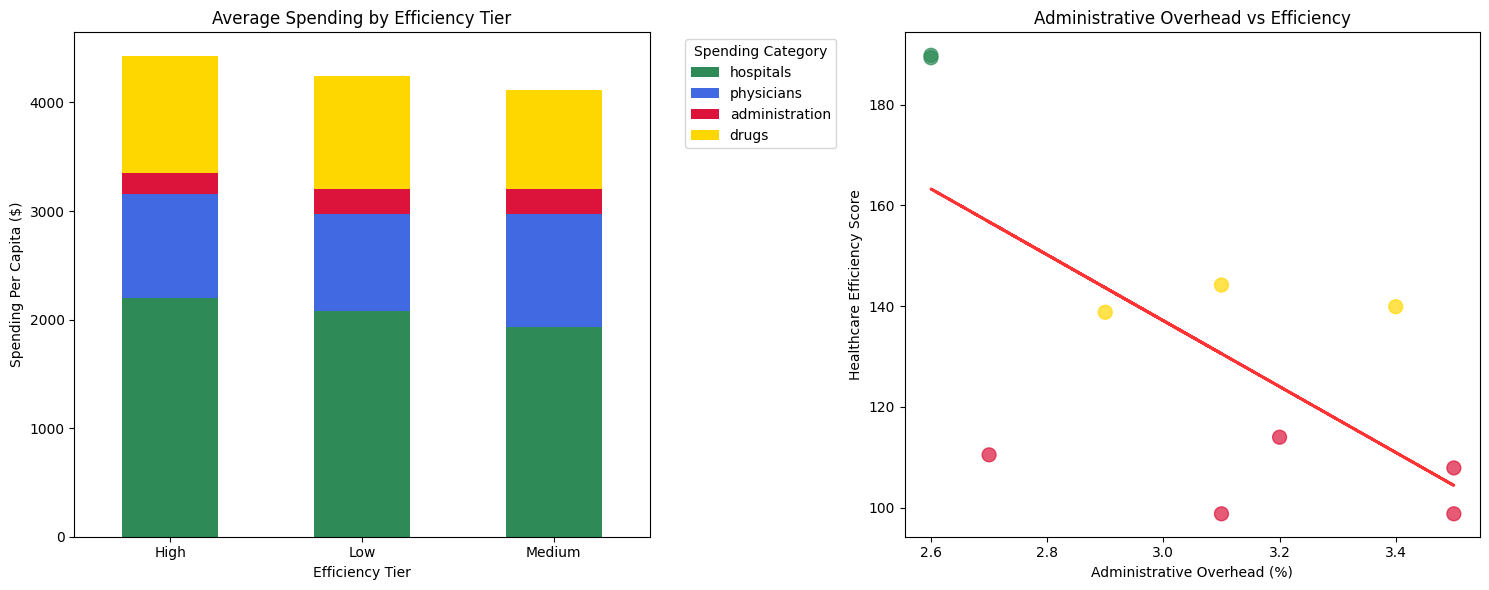

In [6]:
# Create resource allocation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: Spending allocation by efficiency tier
tier_spending = provincial_spending.groupby('efficiency_tier')[['hospitals', 'physicians', 'administration', 'drugs']].mean()
tier_spending.plot(kind='bar', stacked=True, ax=ax1, color=['#2E8B57', '#4169E1', '#DC143C', '#FFD700'])
ax1.set_title('Average Spending by Efficiency Tier')
ax1.set_xlabel('Efficiency Tier')
ax1.set_ylabel('Spending Per Capita ($)')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='Spending Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Chart 2: Administrative overhead vs efficiency
colors = ['#2E8B57' if tier == 'High' else '#FFD700' if tier == 'Medium' else '#DC143C' 
          for tier in provincial_spending['efficiency_tier']]

ax2.scatter(provincial_spending['admin_overhead_pct'], provincial_stats['raw_efficiency'], 
           c=colors, s=100, alpha=0.7)
ax2.set_xlabel('Administrative Overhead (%)')
ax2.set_ylabel('Healthcare Efficiency Score')
ax2.set_title('Administrative Overhead vs Efficiency')

# Add trend line
z = np.polyfit(provincial_spending['admin_overhead_pct'], provincial_stats['raw_efficiency'], 1)
p = np.poly1d(z)
ax2.plot(provincial_spending['admin_overhead_pct'], p(provincial_spending['admin_overhead_pct']), 
         "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()